In [31]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import rasterio
import random

from skimage import io, img_as_float
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from scipy.fft import fft2, fftshift
from scipy.signal import windows

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [111]:
hyp3_sar_fpath = '/Users/kaipak/datasets/SAR_comparison/hyp3_clip.tif'
snap_sar_fpath = '/Users/kaipak/datasets/SAR_comparison/edwin_snap_clip.tif'

In [112]:
# Load GeoTIFF images using rasterio
def load_geotiff(filepath):
    with rasterio.open(filepath) as src:
        image = src.read(1)  # Read the first band
    return image


def sample_tiles(image, tile_size=500, num_tiles=5):
    """
    Sample random tiles from the image ensure no NaNs.
    
    """
    tiles = []
    height, width = image.shape
    
    while len(tiles) < num_tiles:
        x = random.randint(0, width - tile_size)
        y = random.randint(0, height - tile_size)
        tile = image[y:y + tile_size, x:x + tile_size]
        
        # Check if the tile contains any NaNs
        if not np.isnan(tile).any():
            tiles.append(tile)
    
    return tiles

def preprocess_with_mean(tile):
    """
    Replace NaNs in the tile with the mean of the non-NaN values.
    
    """
    mean_value = np.nanmean(tile)
    tile_filled = np.where(np.isnan(tile), mean_value, tile)
    return tile_filled

def analyze_tiles(tiles):
    """
    Perform FFT on the tiles and visualize the results.
    
    """
    for i, tile in enumerate(tiles):
        tile_filled = preprocess_with_mean(tile)
        fft_result = fft2(tile_filled)
        fft_result = fftshift(fft_result)
        
        # Plot the magnitude spectrum
        plt.subplot(1, len(tiles), i + 1)
        plt.imshow(np.log(np.abs(fft_result)), cmap='gray')
        plt.title(f'Tile {i+1}')
        plt.colorbar()

    plt.show()

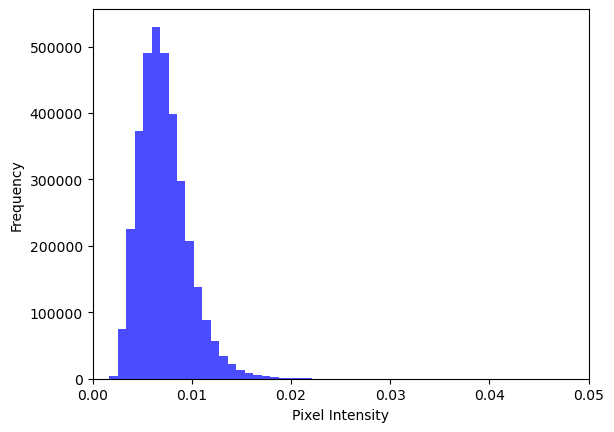

In [133]:
snap_image = load_geotiff(snap_sar_fpath)
# Plot histogram
plt.hist(snap_image.flatten(), bins=5000, color='blue', alpha=0.7)
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
#plt.ylim((0, 1 * 1E7))
plt.xlim((0, .05))
plt.show()

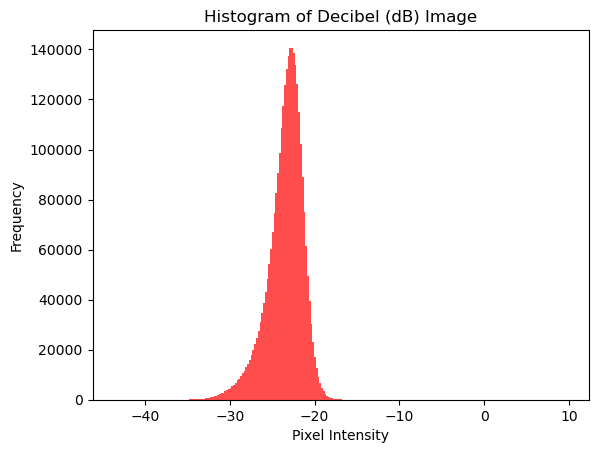

In [123]:
hyp3_image = load_geotiff(hyp3_sar_fpath)
# Plot histogram
plt.hist(hyp3_image.flatten(), bins=256, color='red', alpha=0.7)
plt.title('Histogram of Decibel (dB) Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.show()

In [134]:
hyp3_image

array([[-22.449038, -22.282686, -22.020966, ..., -20.053663, -19.987944,
        -20.482151],
       [-22.268463, -22.054026, -22.137882, ..., -20.483799, -20.531652,
        -20.703426],
       [-21.897278, -21.60547 , -21.999247, ..., -21.06864 , -21.142288,
        -21.054188],
       ...,
       [-25.047419, -24.413647, -23.920818, ..., -21.33678 , -21.6484  ,
        -22.624186],
       [-23.886532, -23.179169, -22.83241 , ..., -21.656343, -21.157555,
        -22.359304],
       [-23.397188, -22.973795, -22.835197, ..., -22.710617, -20.939932,
        -22.328354]], dtype=float32)

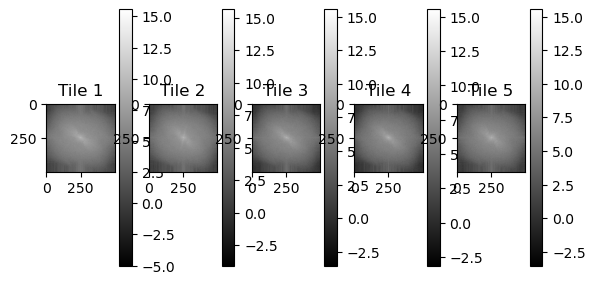

In [135]:
tiles_hyp3 = sample_tiles(hyp3_image, tile_size=500, num_tiles=5)
analyze_tiles(tiles_hyp3)

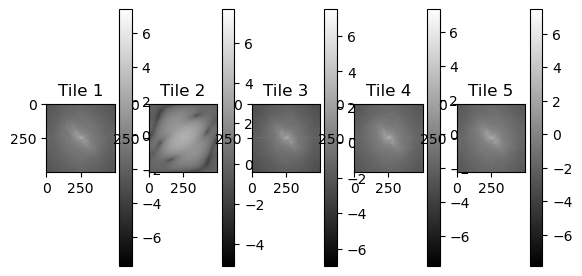

In [136]:
tiles_snap = sample_tiles(snap_image, tile_size=500, num_tiles=5)
analyze_tiles(tiles_snap)

In [137]:
def sample_tiles(image, tile_size=500, num_tiles=5):
    tiles = []
    height, width = image.shape
    
    while len(tiles) < num_tiles:
        x = random.randint(0, width - tile_size)
        y = random.randint(0, height - tile_size)
        tile = image[y:y + tile_size, x:x + tile_size]
        
        if not np.isnan(tile).any():
            tiles.append(tile)
    
    return tiles

def compute_power_spectrum(image, num_bins=100):
    # Apply a window function to reduce edge effects
    window = windows.hamming(image.shape[0])[:, None] * windows.hamming(image.shape[1])
    image_windowed = image * window

    # Perform FFT
    fft_result = fft2(image_windowed)
    fft_result = fftshift(fft_result)
    
    # Compute the power spectrum
    power_spectrum_2d = np.abs(fft_result) ** 2
    
    # Create frequency bins
    y_freqs = np.fft.fftfreq(image.shape[0])
    x_freqs = np.fft.fftfreq(image.shape[1])
    y_freqs = fftshift(y_freqs)
    x_freqs = fftshift(x_freqs)
    
    # Compute radial frequency bins
    y, x = np.meshgrid(y_freqs, x_freqs, indexing='ij')
    r = np.sqrt(x**2 + y**2)
    r = r.flatten()
    power_spectrum_2d = power_spectrum_2d.flatten()
    
    # Aggregate power in radial frequency bins
    freq_bins = np.linspace(0, np.max(r), num=num_bins)
    power_spectrum, _ = np.histogram(r, bins=freq_bins, weights=power_spectrum_2d)
    
    # Normalize the power spectrum
    power_spectrum /= np.histogram(r, bins=freq_bins)[0]
    
    # Convert power spectrum to log scale
    power_spectrum = np.log10(power_spectrum + 1)
    
    # Apply smoothing to the power spectrum
    power_spectrum_smooth = np.convolve(power_spectrum, np.ones(5)/5, mode='same')
    
    return freq_bins[:-1], power_spectrum_smooth

def plot_frequency_power(freq_bins, power_spectrum, label):
    plt.plot(freq_bins, power_spectrum, label=label)




/var/folders/gn/dtxs0nz95d12sr0m6vrm7f6r0000gq/T/ipykernel_17962/896234947.py:44: RuntimeWarning: invalid value encountered in divide
  power_spectrum /= np.histogram(r, bins=freq_bins)[0]


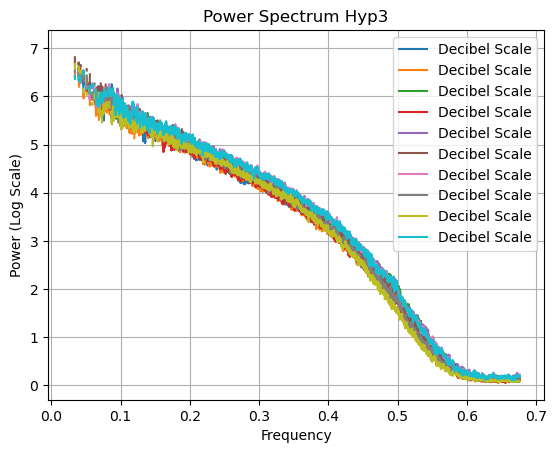

In [139]:
# Sample random tiles
hyp3_tiles = sample_tiles(hyp3_image, tile_size=500, num_tiles=10)

# Process and analyze the tiles
for tile in hyp3_tiles:
    freq_bins, power_spectrum = compute_power_spectrum(tile, num_bins=5000)
    plot_frequency_power(freq_bins, power_spectrum, label='Decibel Scale')

plt.xlabel('Frequency')
plt.ylabel('Power (Log Scale)')
plt.title('Power Spectrum Hyp3')
plt.legend()
plt.grid(True)
plt.show()

/var/folders/gn/dtxs0nz95d12sr0m6vrm7f6r0000gq/T/ipykernel_17962/896234947.py:44: RuntimeWarning: invalid value encountered in divide
  power_spectrum /= np.histogram(r, bins=freq_bins)[0]


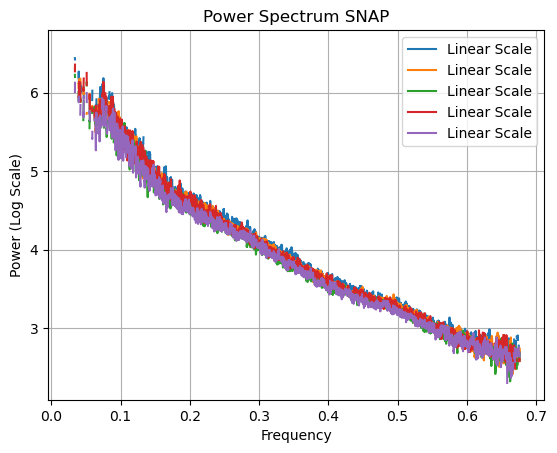

In [140]:
snap_image_log10 = 10 * np.log10(snap_image + 1e-10)
snap_tiles = sample_tiles(snap_image_log10, tile_size=500, num_tiles=5)

# Process and analyze the tiles
for tile in snap_tiles:
    freq_bins, power_spectrum = compute_power_spectrum(tile, num_bins=5000)
    plot_frequency_power(freq_bins, power_spectrum, label='Linear Scale')

plt.xlabel('Frequency')
plt.ylabel('Power (Log Scale)')
plt.title('Power Spectrum SNAP')
plt.legend()
plt.grid(True)
plt.show()


In [145]:

def compute_snr(signal):
    mean_signal = np.mean(signal)
    noise = signal - mean_signal
    snr = 10 * np.log10(np.mean(signal**2) / np.mean(noise**2))
    return snr

snr_hyp3 = [compute_snr(patch) for patch in hyp3_image]
snr_snap = [compute_snr(patch) for patch in snap_image_log10]

avg_snr_hyp3 = np.mean(snr_hyp3)
avg_snr_snap = np.mean(snr_snap)

print("Average SNR for Hyp3:", avg_snr_hyp3)
print("Average SNR for SNAP:", avg_snr_snap)


Average SNR for Hyp3: 21.66469700186953
Average SNR for SNAP: 23.823162112806994


In [146]:
from scipy.signal import welch

def compute_psd(data):
    freqs, psd = welch(data, nperseg=256)
    return freqs, psd

# Example usage
freqs_hyp3, psd_hyp3 = zip(*[compute_psd(patch) for patch in hyp3_data])
freqs_snap, psd_snap = zip(*[compute_psd(patch) for patch in snap_data])


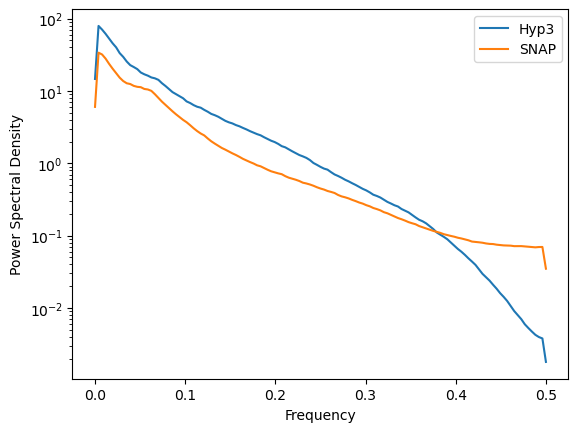

In [147]:
from scipy.signal import welch
import matplotlib.pyplot as plt

def compute_psd(data):
    freqs, psd = welch(data, nperseg=256)
    return freqs, psd

freqs_hyp3, psd_hyp3 = zip(*[compute_psd(patch) for patch in hyp3_image])
freqs_snap, psd_snap = zip(*[compute_psd(patch) for patch in snap_image_log10])

avg_psd_hyp3 = np.mean(psd_hyp3, axis=0)
avg_psd_snap = np.mean(psd_snap, axis=0)

plt.semilogy(freqs_hyp3[0], avg_psd_hyp3, label='Hyp3')
plt.semilogy(freqs_snap[0], avg_psd_snap, label='SNAP')
plt.xlabel('Frequency')
plt.ylabel('Power Spectral Density')
plt.legend()
plt.show()


In [148]:
from scipy.ndimage import gaussian_filter

def compute_rmse(data, sigma=1):
    smoothed_data = gaussian_filter(data, sigma=sigma)
    rmse = np.sqrt(np.mean((data - smoothed_data)**2))
    return rmse

rmse_hyp3 = [compute_rmse(patch) for patch in hyp3_tiles]
rmse_snap = [compute_rmse(patch) for patch in snap_tiles]

avg_rmse_hyp3 = np.mean(rmse_hyp3)
avg_rmse_snap = np.mean(rmse_snap)

print("Average RMSE for Hyp3:", avg_rmse_hyp3)
print("Average RMSE for SNAP:", avg_rmse_snap)


Average RMSE for Hyp3: 0.45555663
Average RMSE for SNAP: 0.36304277
